In [1]:
# Run this cell if you need to connect to G drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set path
%cd "/content/drive/MyDrive/UNSW - Foundation of Cybersecurity/pcp/code/DPGAN"

/content/drive/MyDrive/UNSW - Foundation of Cybersecurity/pcp/code/DPGAN


In [3]:
# Library
import numpy as np
import random
import os
import time
import logging
import sys

from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim, autograd
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# Logger
file_handler = logging.FileHandler(filename='model_WGAN_{ct}.log'.format(ct=time.strftime('%Y%m%d-%H%M')))
stdout_handler = logging.StreamHandler(stream=sys.stdout)
handlers = [file_handler, stdout_handler]
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s.%(msecs)03d %(levelname)s %(module)s - %(funcName)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    handlers=handlers)

In [5]:
# Load data
ct = time.strftime('%Y%m%d-%H%M')
path = r'../data/mnist-digit-0.npz'
data = np.load(path)
data_img = data.get(data.files[0]) / 255.0
N = data_img.shape[0]
p = data_img.reshape(N, -1).shape[1]
li_loss = []
logging.info('*'*30 + '\nModel: WGAN\n' + '*'*30)

In [6]:
# Fix seed
seed = 1030
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [7]:
# Device: gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
logging.info(f'Using {device} device')

In [8]:
class CreateDirs:
    """
    Creates directories for Checkpoints and saving trained models
    Source: https://github.com/MrPandey01/Stiefel_Restricted_Kernel_Machine/blob/main/code/utils.py
    """
    def __init__(self, ct, folder, model):
        self.ct = ct  # checkpoint time
        self.folder = folder
        self.dircp = 'checkpoint.pth_{}.tar'.format(self.ct)
        self.dirout = 'Mul_trained_{}_{}.tar'.format(model, self.ct)

    def create(self):
        # folder for checkpoints
        if not os.path.exists(self.folder+'/cp/'):
            os.makedirs(self.folder+'/cp/')
        # folder for model
        if not os.path.exists(self.folder+'/out/'):
            os.makedirs(self.folder+'/out/')

    def save_checkpoint(self, state, is_best):
        if is_best:
            torch.save(state, self.folder+'/cp/{}'.format(self.dircp))

# Directory for saving
folder = './{dataset}/N-{N}/score/{model}'.format(dataset='MNIST', N=N, model='GAN')
dirs = CreateDirs(ct=ct, folder=folder, model='GAN')
dirs.create()

In [9]:
# ============================================================================
# Data parameters: image size
n_channels = 1
n_width = 28
n_height = 28

# Network parameters
c = 32  # capacity
p_f = 256  # output dimension
p_latent = 100 # latent dimension
alpha = 0.2 # slope for leaky relu

# Training parameters
batch_size = 64 # size of each minibatch
lr_g = 5e-5 # learning rate for generator
lr_d = 5e-5 # learning rate for discriminator
max_epoch = 50000 # maximum number of epochs
n_d = 5 # number of inner loops for discriminator
t_cost = -np.inf # cost to terminate
c_clip = 0.02 # weight-clipping parameters
# ============================================================================

In [10]:
# Preprocessing
def preprocessing(X: np.ndarray):
    X = torch.Tensor(X).type(torch.float32)
    X = torch.Tensor(X).type(torch.float32)
    return X.view(X.size(0), n_channels, n_width, n_height)

data_img = preprocessing(data_img)
p_input = n_channels * n_width * n_height
X = DataLoader(TensorDataset(data_img), batch_size=batch_size, shuffle=True)

In [11]:
# Generator (G)
class ganGenerator(nn.Module):
    """
    Generator function
    :param int p_latent: The dimension of the latent space
    """

    def __init__(self, p_latent: int = p_f):
        super(ganGenerator, self).__init__()
        self.fc1 = nn.Linear(in_features=p_latent, out_features=c * 2 * 7 * 7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c * 2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=alpha)
        if x.dim() == 1:
            x = x.view(1, c * 2, 7, 7)
        else:
            x = x.view(x.size(0), c * 2, 7, 7)
        x = F.leaky_relu(self.conv2(x), negative_slope=alpha)
        x = torch.sigmoid(self.conv1(x))
        return x  # N x 28 x 28

# Discriminator (D)
class ganDiscriminator(nn.Module):
    """
    Discriminator function
    """

    def __init__(self):
        super(ganDiscriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c * 2, kernel_size=4, stride=2, padding=1)
        self.fc1 = torch.nn.Linear(c * 2 * 7 * 7, 1)

    def forward(self, x):
        if x.dim() == 3:
            x = x.view(1, 1, 28, 28)
        x = F.leaky_relu(self.conv1(x), negative_slope=alpha)
        x = F.leaky_relu(self.conv2(x), negative_slope=alpha)
        x = x.view(x.size(0), c * 2 * 7 * 7)
        x = self.fc1(x)
        return x  # N x 1

# Weight clipping
class weightClipper:
    """
    Weight-clipping function
    """

    def __init__(self, c_clip=c_clip):
        self.c_clip = float(c_clip)

    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            w = module.weight.data
            w.clamp_(-self.c_clip, self.c_clip)

# GAN loss functions
def generator_loss(D, G, Z):
    """
    -E[f_w(G(Z))]
    """

    return - torch.mean(D(G(Z)))

def discriminator_loss(D, G, X, Z):
    """
    -E[f_w(X)] + E[f_w(G(Z))]
    """

    return - torch.mean(D(X)) + torch.mean(D(G(Z)))

# Train
def train(X, D, G, optimizer_g, optimizer_d):
    # Initialize
    l_cost = np.inf
    cost = np.inf
    loss_g_holder = []
    loss_d_holder = []
    start = datetime.now()
    epoch = 0
    clipper = weightClipper(c_clip)

    # Training code
    while epoch < max_epoch and cost > t_cost:
        avg_loss_d = 0.0
        avg_loss_g = 0.0

        # train discriminator
        for i, x in enumerate(X, 0):
            if i == n_d:
                break
            z = torch.randn(batch_size, p_latent, device=device)
            x = x[0].to(device)
            loss_d = discriminator_loss(D, G, x, z)
            optimizer_d.zero_grad()
            loss_d.backward()
            optimizer_d.step()
            avg_loss_d += loss_d.item()
            D.apply(clipper)
        avg_loss_d /= n_d

        # train generator
        z = torch.randn(batch_size, p_latent, device=device)
        loss_g = generator_loss(D, G, z)
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        # epoch logging
        INFO = 'epoch: {epoch}'.format(epoch=epoch) + '\t avg. loss: {:10.4f}'.format(float(avg_loss_d)) + '\t loss: {:10.4f}'.format(float(loss_g.item()))
        logging.info(INFO)
        print(INFO)
        loss_d_holder.append(avg_loss_d)
        loss_g_holder.append(loss_g.item())
        cost = avg_loss_d
        epoch += 1


        # Remember lowest cost and save checkpoint
        is_best = cost < l_cost
        l_cost = min(cost, l_cost)
        dirs.save_checkpoint({
            'epochs': epoch + 1,
            'generator_state_dict': G.state_dict(),
            'discriminator_state_dict': D.state_dict(),
            'l_cost': l_cost,
            'optimizer_g': optimizer_g.state_dict(),
            'optimizer_d': optimizer_d.state_dict(),
        }, is_best)

In [12]:
# GAN models
G = ganGenerator(p_latent=p_latent).to(device)
D = ganDiscriminator().to(device)

# GAN optimizers
optimizer_g = optim.RMSprop(list(G.parameters()), lr=lr_g)
optimizer_d = optim.RMSprop(list(D.parameters()), lr=lr_d)

train(X, D, G, optimizer_g, optimizer_d)

Streaming output truncated to the last 5000 lines.
epoch: 45000	 avg. loss:    -0.0066	 loss:    -2.9572
epoch: 45001	 avg. loss:    -0.0048	 loss:    -2.9220
epoch: 45002	 avg. loss:    -0.0034	 loss:    -2.9187
epoch: 45003	 avg. loss:    -0.0054	 loss:    -2.9125
epoch: 45004	 avg. loss:    -0.0060	 loss:    -2.8938
epoch: 45005	 avg. loss:    -0.0069	 loss:    -2.9039
epoch: 45006	 avg. loss:    -0.0043	 loss:    -2.9307
epoch: 45007	 avg. loss:    -0.0095	 loss:    -2.9669
epoch: 45008	 avg. loss:    -0.0044	 loss:    -2.9611
epoch: 45009	 avg. loss:    -0.0112	 loss:    -2.9629
epoch: 45010	 avg. loss:    -0.0043	 loss:    -2.9670
epoch: 45011	 avg. loss:    -0.0010	 loss:    -2.9750
epoch: 45012	 avg. loss:    -0.0085	 loss:    -3.0072
epoch: 45013	 avg. loss:    -0.0053	 loss:    -2.9916
epoch: 45014	 avg. loss:    -0.0107	 loss:    -3.0057
epoch: 45015	 avg. loss:    -0.0047	 loss:    -2.9685
epoch: 45016	 avg. loss:    -0.0070	 loss:    -2.9815
epoch: 45017	 avg. loss:    -0.

Text(0.5, 0.98, 'WGAN ($\\epsilon=\\infty$)')

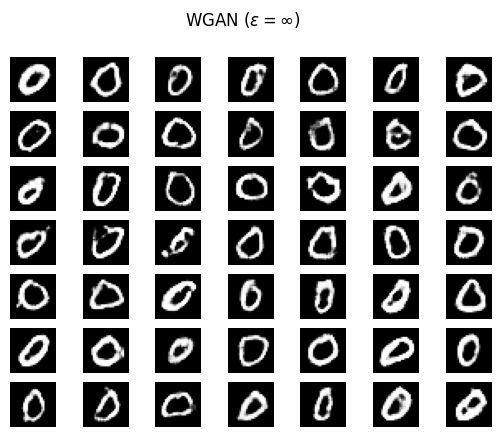

In [19]:
G_cpu = G.cpu()
torch.manual_seed(0)
n_plt = 7
z = torch.randn(n_plt*n_plt, 100)
x_hat = G_cpu(z)

from matplotlib import pyplot as plt
f, ax = plt.subplots(n_plt, n_plt)

num = 0
for i in range(n_plt):
    for j in range(n_plt):
        ax[i, j].imshow(x_hat[num].detach().numpy().reshape(28, 28), cmap='gray')
        ax[i, j].axis('off')
        num += 1
f.suptitle("WGAN ($\epsilon=\infty$)")

In [15]:
D

ganDiscriminator(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=1, bias=True)
)

In [16]:
G

ganGenerator(
  (fc1): Linear(in_features=100, out_features=3136, bias=True)
  (conv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [ ]:
# Scratch [Check tensor sizes]
p_latent = 10
batch_size = 128

G = ganGenerator(p_latent=p_latent)
D = ganDiscriminator()
z = torch.randn(batch_size, p_latent)

print('Shape of z:\t\t', z.shape)
print('Shape of G(z):\t\t', G(z).shape)
print('Shape of D(G(z)):\t', D(G(z)).shape)